In [447]:
!date

Tue Jul 16 23:59:03 EDT 2019


# Workforce Prediction

In this notebook, we tried to predict the inbound & outbound traffic from the warehouse, in order to help allocate workforce. Noted that the max capacity of the warehouse is 3500 orders/day as of July 2019, but our predictions are not limited by that. 

There are six types of warehouse activities: 
1. Outbound customer order
2. Outbound items transfer
3. Outbound purchase order return
4. Inbound customer return
5. Inbound items transfer
6. Inbound purchase order

We will focus on predicting the `Outbound Customer Order` here

## Imports and settings 

In [1]:
#### disable the sdout logging of fbprophet 

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

### ignore the pystan DeprecationWarning

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline

import os
import sys 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.offline as py
import cufflinks as cf
cf.go_offline()

### some metrics and stats

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

#### we use the convenient

import holidays

#### fbprophet 

import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

fbprophet.__version__

Prophet = fbprophet.Prophet

### import some utility functions for data munging and plotting 

sys.path.append('queries/')

import utils as utils
pd.plotting.register_matplotlib_converters() ## bugs.. fbprophet & matplotlib


import warnings
warnings.filterwarnings("ignore")


# df = cf.datagen.lines()

# py.iplot([{
#     'x': df.index,
#     'y': df[col],
#     'name': col
# }  for col in df.columns], filename='cufflinks/simple-line')

### Import Data

In [2]:
# ``` mysql
# SQL from Google Big Query 
# WITH CALC AS (
# SELECT 
#            l_order_item_id as oi_id
#           ,pickticket_id
#           ,timestamp(pickticket_created_at,'UTC') as pickticket_created_at 
#           ,timestamp(pickticket_updated_at,'UTC') as pickticket_sent_at 
#           ,l_quantity as order_amount
# FROM `moda-operandi-dw.dw_production.sc__sales_order_picktickets` 
# ORDER BY pickticket_sent_at ASC
# )
# ,
# CALC2 AS ( ## TAKING THE LATEST PICKTICKET SENT (By oi_id)/ THE FIRST PICKTICKET CREATED ## WE SOMETIMES SEND MORE PTS WHEN PREVIOUS FAILS ##
#     SELECT
#            *
#           ,row_number() over (partition by oi_id order by pickticket_created_at asc, pickticket_sent_at asc) as min_created_order
#           ,row_number() over (partition by oi_id order by pickticket_sent_at desc, pickticket_created_at desc) as max_sent_order
#     FROM CALC
# )
# ,
# CALC3 AS(
#     SELECT
#            *,
#            date(CALC2.pickticket_created_at) as date_utc
#     FROM CALC2
#     WHERE
#          min_created_order = 1 AND date(pickticket_created_at) >= '2016-01-01' 
#     ORDER BY pickticket_created_at ASC
# )
# SELECT date_utc, sum(order_amount) as out_cust_order_qty
# FROM CALC3
# GROUP BY date_utc
# ORDER BY date_utc ASC
# ;
# ```

In [450]:
#### Read the customer order data
dat = pd.read_csv('data/out_cust_order_qty.csv')
# Drop last 5 days in case data is incomplete
dat.drop(dat.tail(5).index,inplace=True)
dat.index = pd.to_datetime(dat.date_utc)
dat.drop(["date_utc"],axis=1,inplace=True)

In [3]:
#### Read the customer order data from gbq (update real time)
from google.cloud import bigquery as bq
client = bq.Client()
with open( 'queries/customer_orders_query.sql') as f:
    q_customer_orders = f.read()
dat_realtime = client.query(q_customer_orders).to_dataframe()
dat_realtime.tail()

ImportError: cannot import name 'bigquery' from 'google.cloud' (unknown location)

In [452]:
#### Read Inventory Data from MK
# dat_full = pd.read_csv('data/inventory_in_out_mk.csv')
# dat_full.index = pd.to_datetime(dat_full.date_utc)
# dat_full.drop(["date_utc"],axis=1,inplace=True)

In [665]:
#### Read current prediction data from forecast team
dat_curr_prediction = pd.read_csv('data/inven_curr_predictions.csv')
dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_OUT_Ord']]
dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_OUT_Ord':'out_cust_order_qty_curr'},inplace=True)
dat_curr_prediction.index = pd.to_datetime(dat_curr_prediction['ds'])
dat_curr_prediction.drop(["ds"],axis=1,inplace=True)
dat_curr_prediction.head()

,out_cust_order_qty_curr
ds,
2019-05-19,2144.79
2019-05-20,1884.79
2019-05-21,2088.79
2019-05-22,1868.79
2019-05-23,1696.51


In [454]:
#### Read holiday/markdown info
holidays_hack = pd.read_csv('data/holiday_test.csv')

In [455]:
#### Read holiday from gbq NEED CREDENTIAL

from google.cloud import bigquery as bq
client = bq.Client()
query_job = client.query("""
    SELECT * 
    FROM `moda-operandi-dw.adhoc_analytics.ds_forecast_holidays_sample_2a` 
    LIMIT 1000
""")
results = query_job.to_dataframe()
holidays_full = results

## Exploratory Analysis - Customer Order 

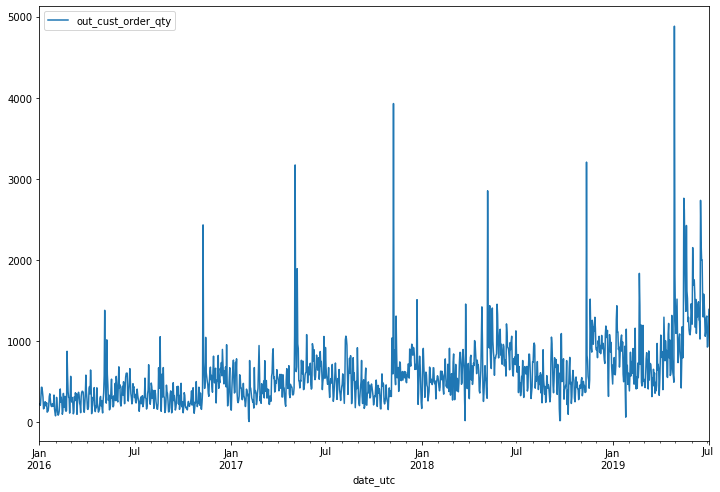

In [456]:
f, ax = plt.subplots(figsize=(12,8))
dat.plot(ax=ax)

In [457]:
# Order large than 2000
dat.loc[dat['out_cust_order_qty']>=1800,:]

,out_cust_order_qty
date_utc,
2016-11-09,2430
2017-05-04,3170
2017-05-08,1890
2017-11-08,3928
2018-05-07,2851
2018-11-12,3205
2019-02-21,1832
2019-04-29,4883
2019-04-30,1806


### Plot TS vs 30 days MA

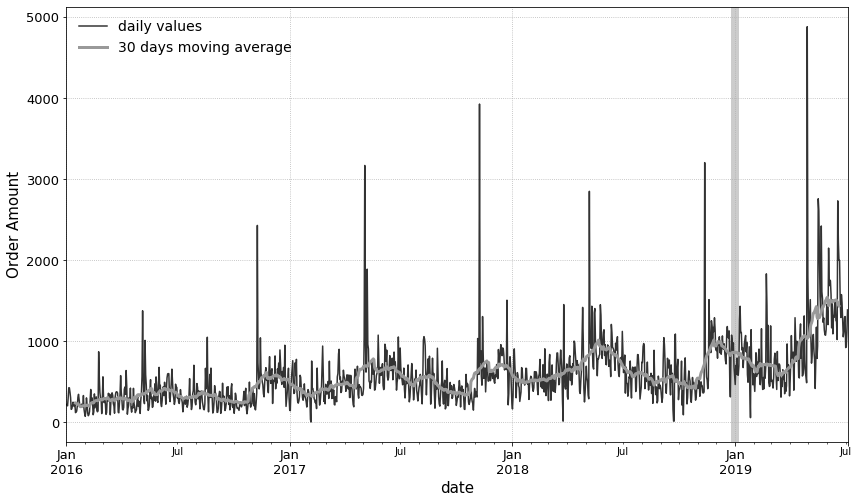

In [458]:
f, ax = plt.subplots(figsize=(14,8))

dat.plot(ax=ax, color='0.2')

dat['out_cust_order_qty'].rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days moving average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Order Amount', fontsize=15);

ax.axvline('2019', color='0.8', lw=8, zorder=-1)

for ext in ['png']: 
    f.savefig(f'figures/customer_order_count.{ext}', dpi=200)

### Monthly seasonality?

In [459]:
dat_monthly = dat
dat_monthly['day_of_month'] = dat_monthly.index.day
dat_monthly['day_of_week'] = dat_monthly.index.dayofweek
dat_monthly['month'] = dat_monthly.index.month

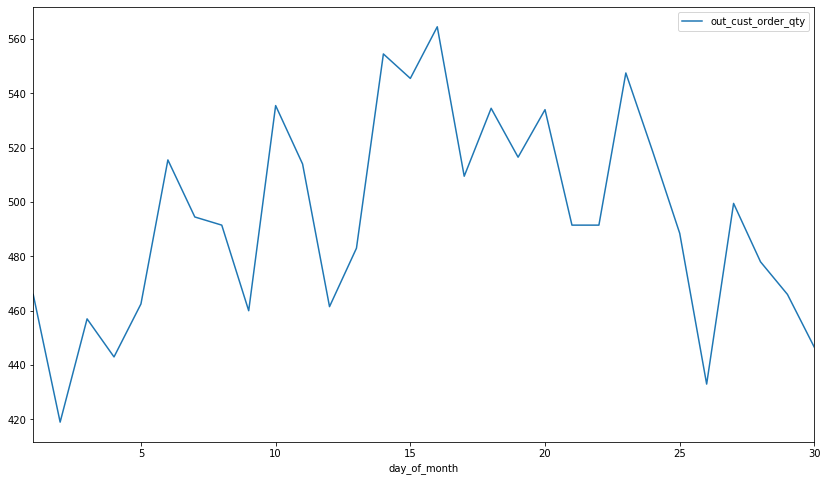

In [460]:
_, ax = plt.subplots(figsize=(14,8))
dat_monthly.loc[:, ['day_of_month','out_cust_order_qty']].groupby('day_of_month').median().head(30).plot(ax=ax) # use median in order to be robust to outliers


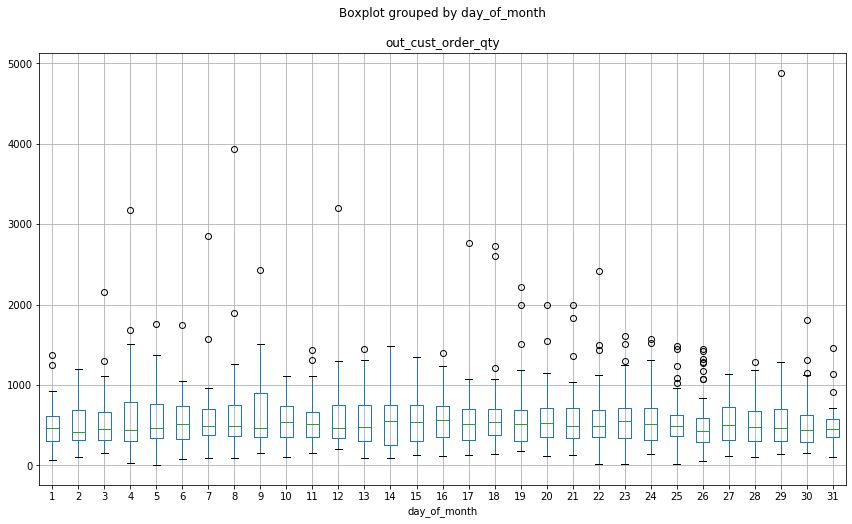

In [461]:
_, ax = plt.subplots(figsize=(14,8))
# dat_monthly.plot.scatter(x='day_of_month',y='out_cust_order_qty',ax=ax)
dat_monthly.boxplot(column='out_cust_order_qty',by='day_of_month',ax=ax)

# dat_monthly.boxplot(column='out_cust_order_qty',by='month',ax=ax)


No seasonality by month..

## FB Prophet Model

### Data Preparation
 (Could try not split and use in place rolling validation..)

In [672]:
# import importlib
# importlib.reload(utils)

split_date = '2019-05-19'  # Setting the train test cutoff date
forward_days = 200  # set up how
log_transform = False
local = False

In [673]:
if local == True:
    df = pd.DataFrame()
    df['y'] = dat.out_cust_order_qty.values
    df.index = dat.index.rename("ds")
else:
    df = dat_realtime.copy()
    df.index = pd.to_datetime(df.ds)
    df.drop(columns="ds", inplace = True)


In [674]:
dat_train, dat_test = utils.prepare_data(df, date=split_date)

In [675]:
dat_train.tail()

,ds,y
1229,2019-05-14,1174
1230,2019-05-15,788
1231,2019-05-16,942
1232,2019-05-17,2759
1233,2019-05-18,2609


In [676]:
dat_all = pd.concat([dat_train,dat_test])
dat_all.shape

(1293, 2)

In [677]:
# Filter the outliers
dat_all_filtered = dat_all.copy()
dat_all_filtered.loc[:,'y'] = utils.median_filter(dat_all, varname='y')

### Baseline Model

#### Model set up

In [678]:
m = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False 
           )

m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False 
           )

# Seasonality set to multiplicative to capture the increasing variances


In [679]:
m.fit(dat_train)
m_full.fit(dat_all)

### Test

In [680]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')

In [681]:
forecast = m.predict(future)

In [685]:
# forecast.loc[forecast.ds>='2019-04-29',:].head()

### Validation I

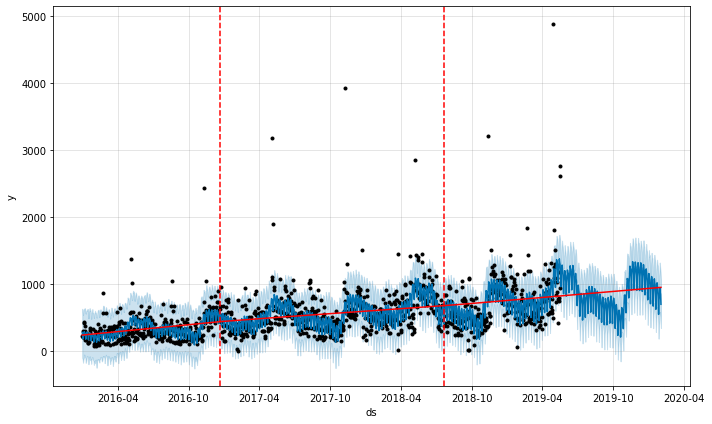

In [683]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

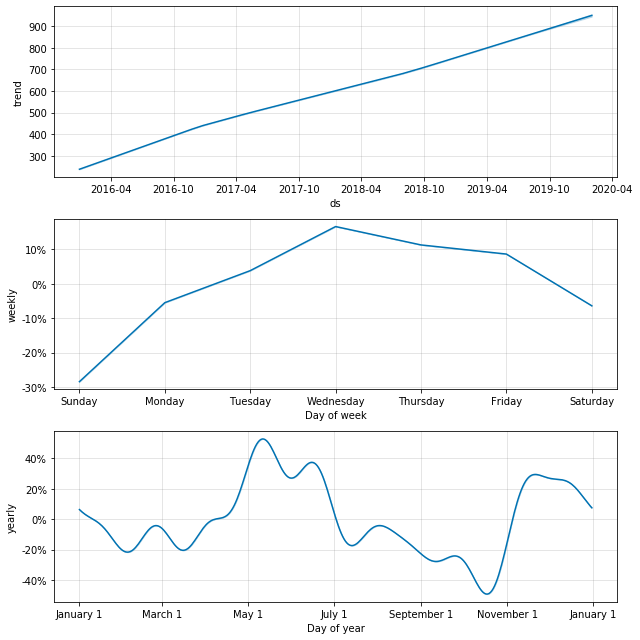

In [686]:
f = m.plot_components(forecast)

### Validation II

#### Prediction Overview

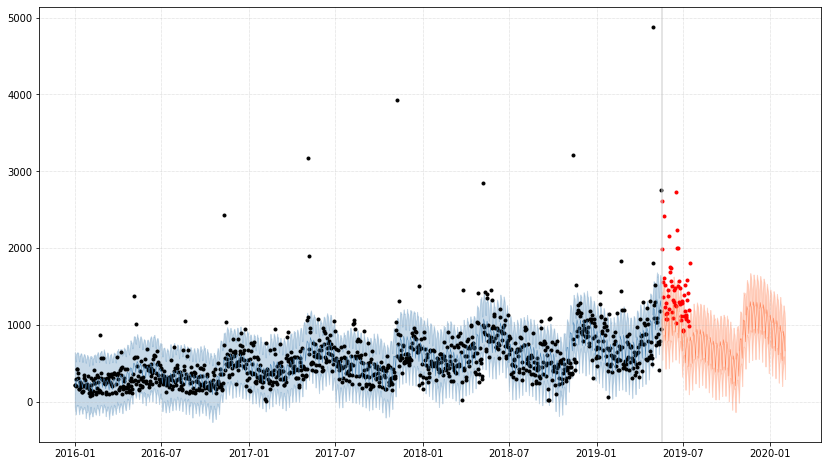

In [475]:
verif = utils.make_verif(forecast, dat_train, dat_test)
if log_transform == True:
    #### for log transform
    verif['y'] = np.exp(verif['y'])
    verif['yhat'] = np.exp(verif['yhat'])
    verif['yhat_upper'] = np.exp(verif['yhat_upper'])
    verif['yhat_lower'] = np.exp(verif['yhat_lower'])

f = utils.plot_verif(verif,date=split_date)

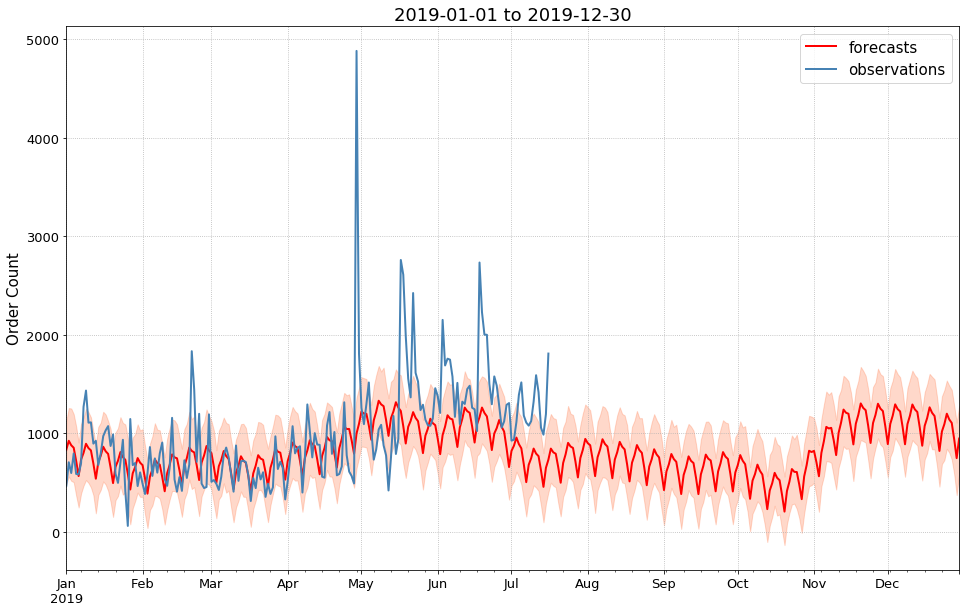

In [476]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)

utils.make_plot_block(verif, '2019-01-01', '2019-12-30', ax=ax)


# for ext in ['png']: 
#     f.savefig('../figures/forecasts_obs.{}'.format(ext), dpi=200)

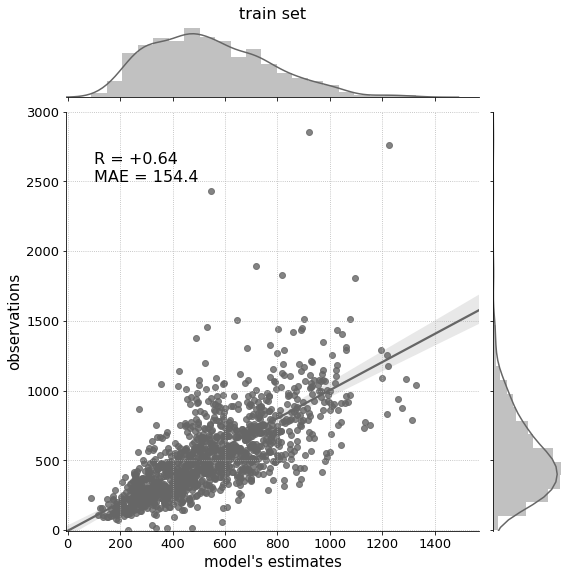

In [477]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

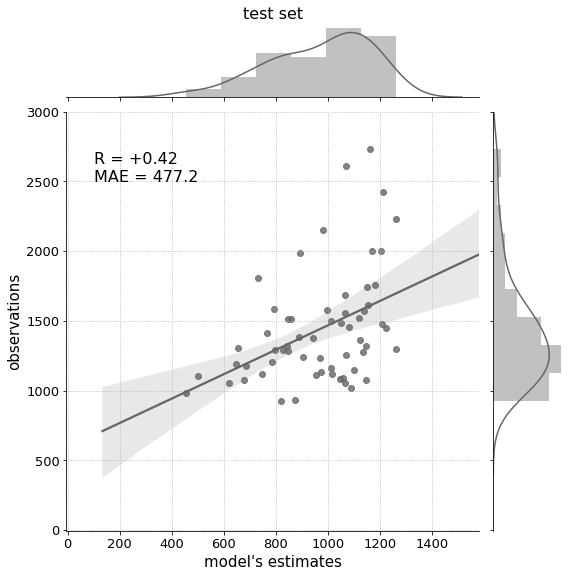

In [478]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

Text(0.5, 1.0, 'Residuals distribution (train set)')

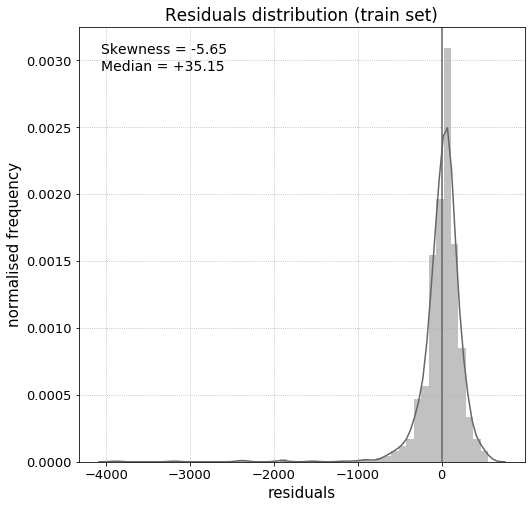

In [479]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(
verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'yhat'] \
                    - verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'y']\
    , ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'yhat'] \
                    - verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'y'])\
               ,(verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'yhat']\
                - verif.loc[(verif.index<split_date) &(verif['y'].notnull()) ,'y']).median()),fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (train set)', fontsize=17)

# for ext in ['png']: 
#     f.savefig(f'figures/residuals_distribution_train_set.{ext}', dpi=200)
    

Text(0.5, 1.0, 'Residuals distribution (test set)')

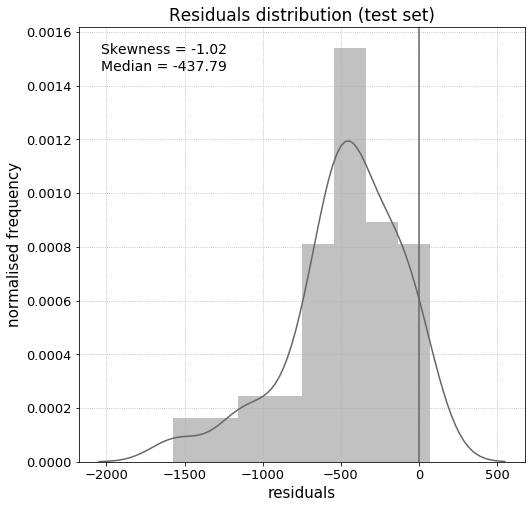

In [480]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(
verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'yhat'] \
                    - verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'y']\
    , ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'yhat'] \
                    - verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'y'])\
               ,(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'yhat']\
                - verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,'y']).median()),fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

# for ext in ['png']: 
#     f.savefig(f'figures/residuals_distribution_test_set.{ext}', dpi=200)

The residual chart indicate we are underestimate for some cases.. but overall it looks good

### Validation III - CV rolling from FB paper

In [481]:
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [482]:
# This is from Prophet
df_cv = cross_validation(m_full, initial='730 days', period='15 days', horizon = '14 days')

In [483]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,2 days,115094.986895,339.256521,235.686841,0.275987,0.709621
1,3 days,88797.996327,297.989927,218.837063,0.253863,0.707483
2,4 days,127528.096476,357.110762,256.376080,0.304160,0.703154
3,5 days,99571.754076,315.549923,236.819966,0.301780,0.688209
4,6 days,71740.119848,267.843461,211.687000,0.267956,0.720117


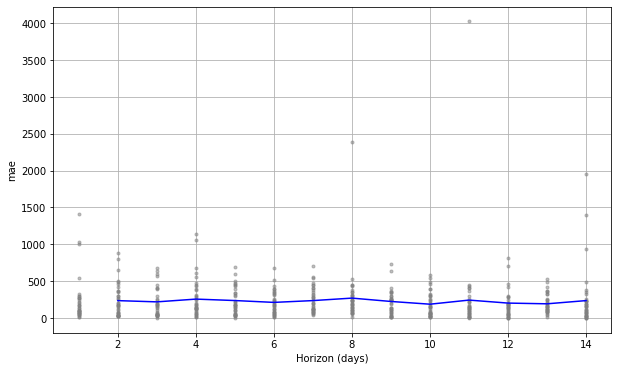

In [484]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
# df_p[['mape']].plot()

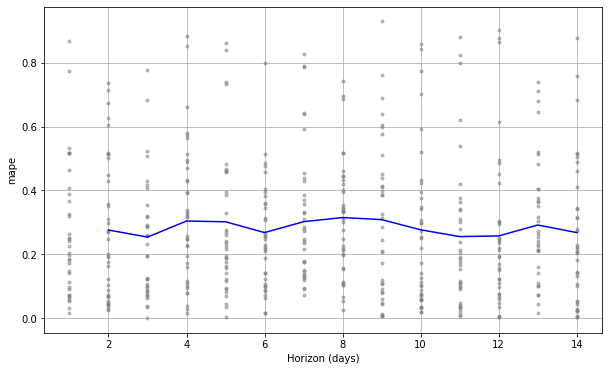

In [485]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Simulate one day prediction

In [486]:
# Use Model m_full
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [487]:
m_full.history_dates.tail()

55   2019-07-12
56   2019-07-13
57   2019-07-14
58   2019-07-15
59   2019-07-16
Name: ds, dtype: datetime64[ns]

In [488]:
# Use Rolling method to simulate predicting next date value
df_cv = cross_validation(m_full, initial='1220 days', period='1 days', horizon = '1 days')

In [489]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,235854.654207,485.648694,358.773391,0.264225,0.638889


In [490]:
df_one_day_pred = df_cv.loc[:,['ds','yhat','yhat_lower','yhat_upper']]
df_one_day_pred.index = df_one_day_pred['ds']
df_one_day_pred.tail(5)

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
2019-07-12,2019-07-12,1051.059336,689.754629,1384.127566
2019-07-13,2019-07-13,899.638712,524.461329,1265.102646
2019-07-14,2019-07-14,709.367616,377.244452,1091.023590
2019-07-15,2019-07-15,925.434018,572.654102,1299.529681
2019-07-16,2019-07-16,1035.984305,647.505809,1395.679245


#### Compare with our current Excel method

In [491]:
dat_curr_prediction.head()

,out_cust_order_qty_curr
ds,
2019-05-19,2144.79
2019-05-20,1884.79
2019-05-21,2088.79
2019-05-22,1868.79
2019-05-23,1696.51


In [492]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['ds','yhat_lower','yhat_upper','yhat','y','out_cust_order_qty_curr'])

verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':'TS Model', 'out_cust_order_qty_curr':'Current Excel Model'} ,inplace=True)
verif_comp_2 = verif_comp.drop(columns=['ds']).reset_index().join(df_one_day_pred,rsuffix="_2",on="ds")
verif_comp_2.index = verif_comp_2['ds']
verif_comp_2.rename(columns = {'yhat':'Prophet Daily Simulation'}, inplace=True)

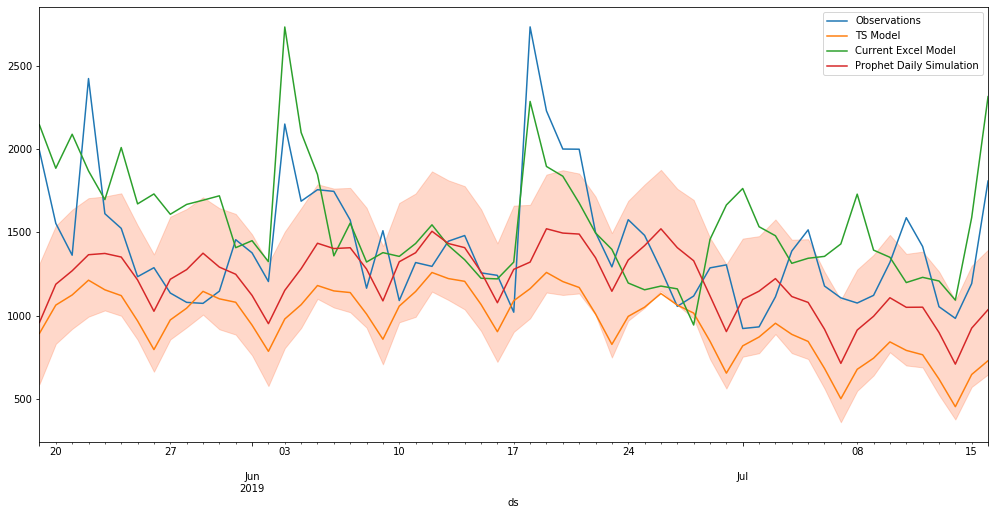

In [493]:
_, ax = plt.subplots(figsize=(17,8))
verif_comp_2.loc[:,['Observations','TS Model','Current Excel Model','Prophet Daily Simulation']].plot(ax=ax)
ax.fill_between(verif_comp_2.index, verif_comp_2.loc[:,'yhat_lower_2'], verif_comp_2.loc[:,'yhat_upper_2'], color='coral', alpha=0.3)



In [494]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(verif_comp_2['Current Excel Model'] - verif_comp_2['Observations'])/verif_comp_2['Observations'])))
print('MAPE of the Prophet Daily Model ' + str(np.mean(np.abs(verif_comp_2['Prophet Daily Simulation'] - verif_comp_2['Observations'])/verif_comp_2['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp_2['TS Model'] - verif_comp_2['Observations'])/verif_comp_2['Observations'])))


MAPE of the Current Model 0.21678561658887704
MAPE of the Prophet Daily Model 0.20246838834381836
MAPE of the Prophet Model Up Until 2019-05-18  0.299519118965629


## Baseline Model With Holiday / Regressors to Capture the Promotion Event

#### Model set up

In [805]:
# def outlier_flag(df, varname = None, window=24, std=3): 
#     dfc = df.loc[:,[varname]]
#     dfc['median']= dfc[varname].rolling(window, center=True).median()
#     dfc['std'] = dfc[varname].rolling(window, center=True).std()
#     dfc['outliers'] = ((dfc.loc[:,varname] - (dfc['median']+std*dfc['std'])) >0) | ((dfc.loc[:,varname] - (dfc['median']-std*dfc['std'])) <0)
#     dfc['outliers'] = dfc['outliers'].astype(int)
#     dfc = pd.concat([dfc[['outliers']],df], axis=1)
#     dfc.loc[:,['ds','outliers']]
#     return dfc.loc[:,['ds','outliers']]

# #### prepare holiday ds
# holidays = outlier_flag(dat_all,varname= 'y').query('outliers==1')[['ds']]
# holidays['holiday'] = 'Major Sales'
# holidays['lower_window'] = 0
# holidays['upper_window'] = 5
# holidays


# holidays = pd.read_csv('data/holiday_update_0716.csv')
# holidays.tail()

holidays = holidays_full
holidays

,ds,holiday,lower_window,upper_window,flag_data
0,2016-11-09,VIP Sale,0,5,NaN
1,2017-05-04,VIP Sale,0,5,NaN
2,2018-11-12,VIP Sale,0,5,1.0
3,2017-11-08,VIP Sale,-3,5,NaN
4,2016-05-05,VIP Sale,0,5,NaN
5,2018-05-07,VIP Sale,0,8,1.0
6,2019-04-29,VIP Sale,0,17,NaN
7,2016-12-16,Markdowns,0,3,NaN
8,2018-01-01,Markdowns,0,7,NaN
9,2017-05-26,Markdowns,0,13,NaN


In [708]:
m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

In [709]:
m.fit(dat_train)
m_full.fit(dat_all)

### Test

In [710]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')

In [711]:
forecast = m.predict(future)

In [712]:
forecast.loc[forecast.ds>=split_date,:].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Employee Sale,Employee Sale_lower,Employee Sale_upper,Extra % Off Promo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1234,2019-05-19,864.919832,1035.650600,1431.552013,864.919832,864.919832,0.0,0.0,0.0,0.0,...,-0.309451,-0.309451,-0.309451,0.452912,0.452912,0.452912,0.0,0.0,0.0,1237.521128
1235,2019-05-20,866.732369,1196.872772,1633.059292,866.732369,866.732369,0.0,0.0,0.0,0.0,...,-0.156723,-0.156723,-0.156723,0.454066,0.454066,0.454066,0.0,0.0,0.0,1416.812555
1236,2019-05-21,868.544907,1450.842615,1864.940500,868.544907,868.544907,0.0,0.0,0.0,0.0,...,0.086708,0.086708,0.086708,0.452620,0.452620,0.452620,0.0,0.0,0.0,1655.466469
1237,2019-05-22,870.357444,2231.317514,2662.051845,870.357444,870.357444,0.0,0.0,0.0,0.0,...,0.207349,0.207349,0.207349,0.448767,0.448767,0.448767,0.0,0.0,0.0,2458.863269
1238,2019-05-23,872.169982,1652.255153,2053.608121,872.169982,872.169982,0.0,0.0,0.0,0.0,...,0.134687,0.134687,0.134687,0.442746,0.442746,0.442746,0.0,0.0,0.0,1855.768108


### Validation

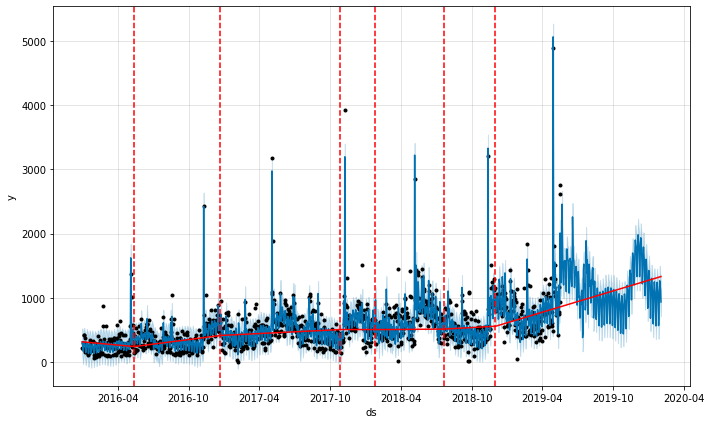

In [713]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

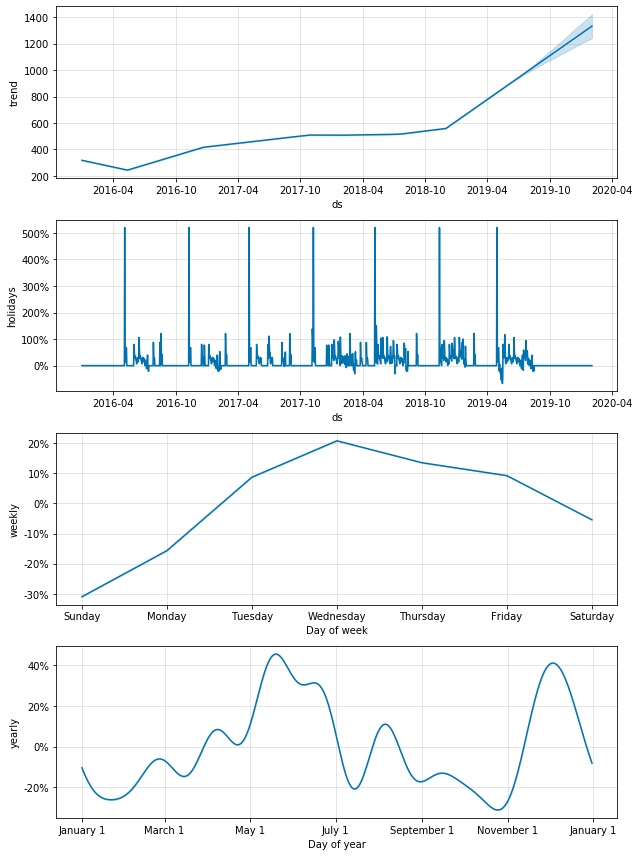

In [714]:
f = m.plot_components(forecast)

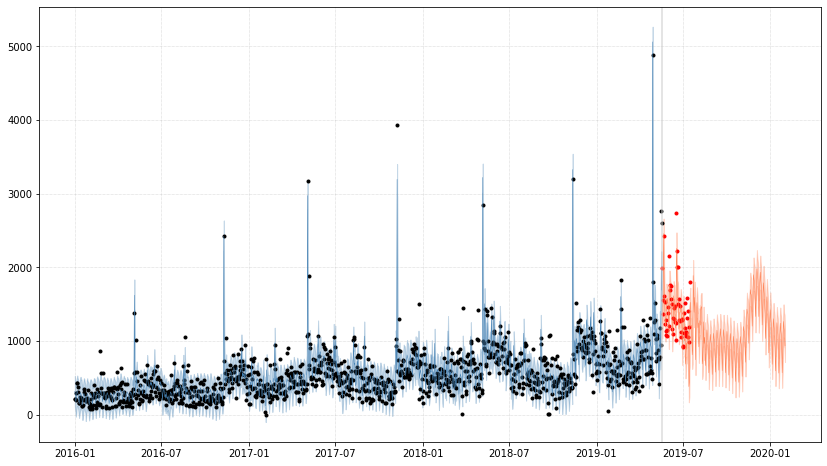

In [716]:
verif = utils.make_verif(forecast, dat_train, dat_test)
f = utils.plot_verif(verif,date=split_date)

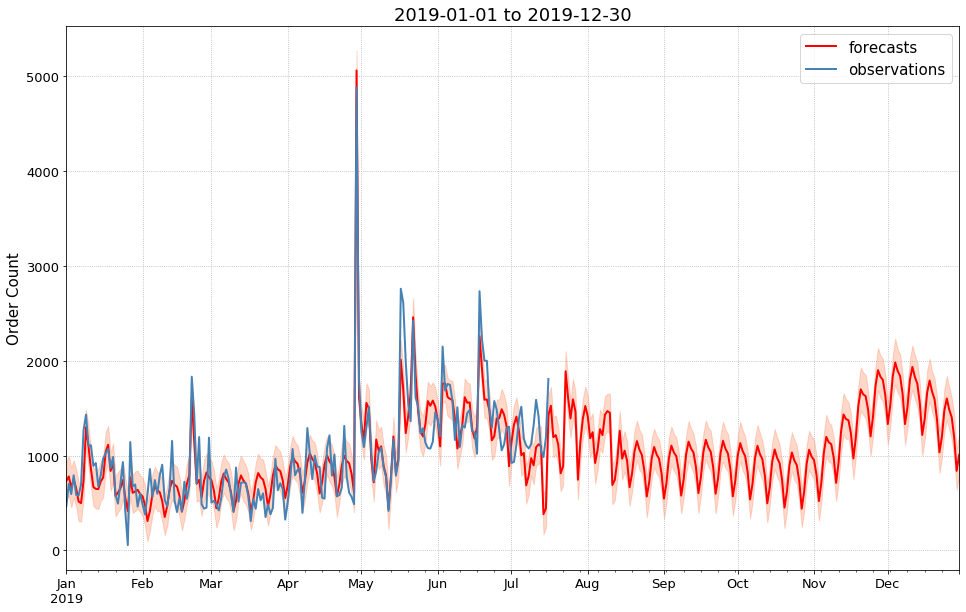

In [717]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)

utils.make_plot_block(verif, '2019-01-01', '2019-12-30', ax=ax)


# for ext in ['png']: 
#     f.savefig('../figures/forecasts_obs.{}'.format(ext), dpi=200)

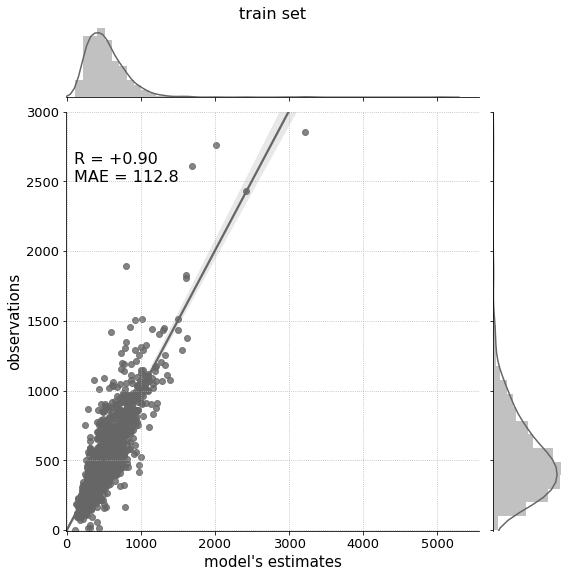

In [718]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

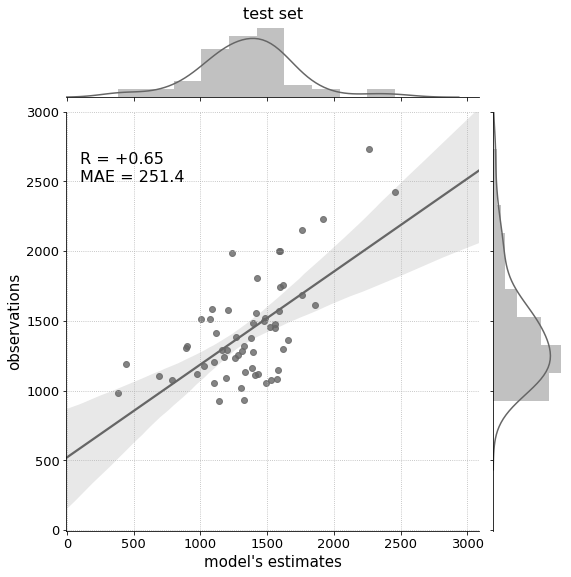

In [719]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

In [720]:
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'VIP Sale',
  'Markdowns',
  'Tiered Promo',
  'Employee Sale',
  'Full Price Promo',
  'Extra % Off Promo',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [721]:
# This is from Prophet
df_cv = cross_validation(m_full, initial='730 days', period='30 days', horizon = '14 days')

In [727]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,2 days,44256.108138,210.371358,161.449919,0.236782,0.670040
1,3 days,44603.969739,211.196519,165.174584,0.232002,0.595142
2,4 days,52120.303522,228.298716,189.462906,0.288907,0.555556
3,5 days,63461.031788,251.914731,203.311196,0.324451,0.534188
4,6 days,65416.117419,255.765747,209.076627,0.275300,0.564777


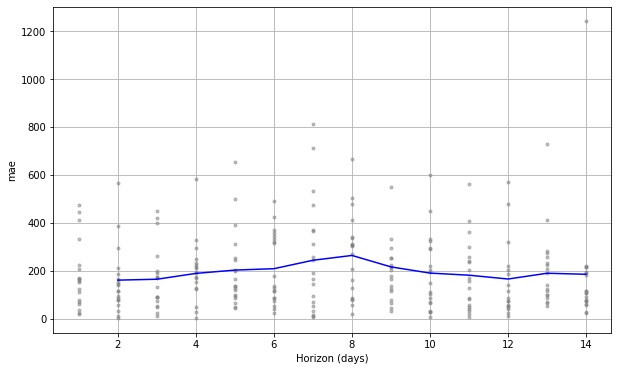

In [728]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
# df_p[['mae']].plot()

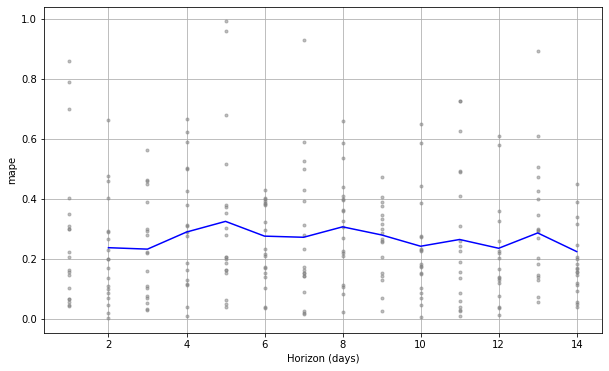

In [729]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

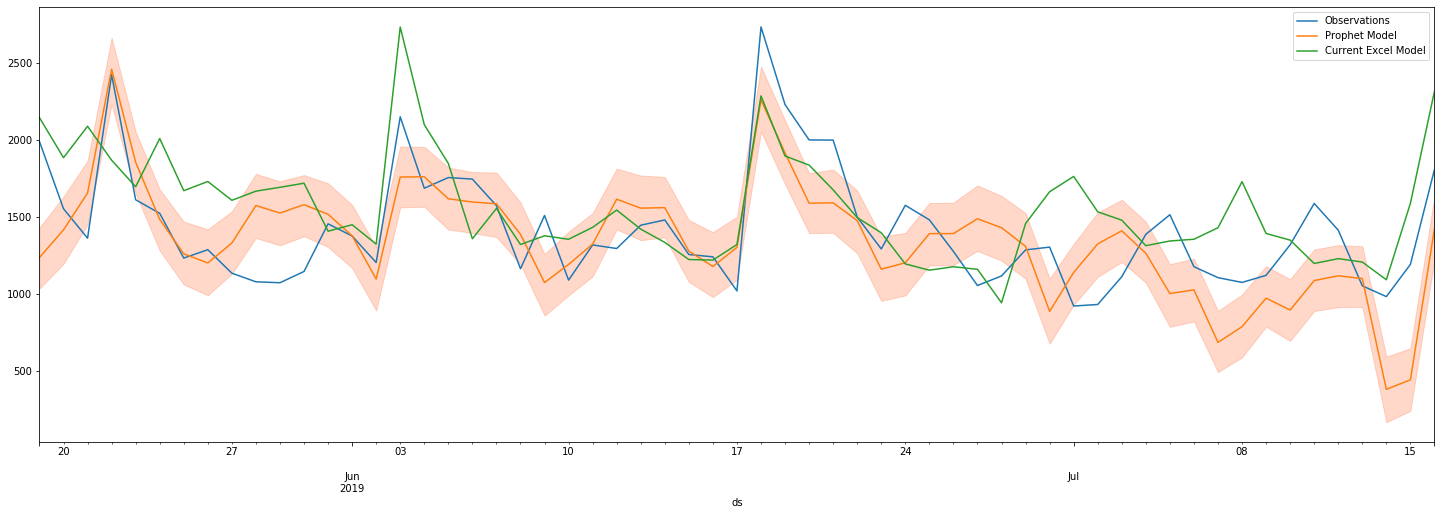

In [730]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['ds','yhat_lower','yhat_upper','yhat','y','out_cust_order_qty_curr'])
verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':'Prophet Model', 'out_cust_order_qty_curr':'Current Excel Model'} ,inplace=True)
_, ax = plt.subplots(figsize=(25,8))
verif_comp.loc[:,['Observations','Prophet Model','Current Excel Model']].plot(ax=ax)
ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)



In [731]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations'])/verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp['Prophet Model'] - verif_comp['Observations'])/verif_comp['Observations'])))


MAPE of the Current Model 0.21678561658887704
MAPE of the Prophet Model Up Until 2019-05-19  0.18758273155932775


## Baseline Model With `X^expand_factors` Transformation

#### Model set up

In [862]:
# #### prepare holiday ds
# holidays = outlier_flag(dat_all,varname= 'y').query('outliers==1')[['ds']]
# holidays['holiday'] = 'Major Sales'
# holidays.head()

# Set Expand Factors to let model overestimate
expand_factors = 1.05


In [863]:
m = Prophet(changepoint_prior_scale=0.01, changepoint_range=0.8 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

In [864]:
# Transform
dat_train_transformed = dat_train.copy()
dat_all_transformed = dat_all.copy()
dat_train_transformed['y'] = dat_train_transformed['y'] ** expand_factors
dat_all_transformed['y'] = dat_all_transformed['y'] ** expand_factors
dat_train_transformed.head()

,ds,y
0,2016-01-01,288.100369
1,2016-01-02,282.602786
2,2016-01-03,264.771259
3,2016-01-04,396.211500
4,2016-01-05,576.607224


In [865]:

m.fit(dat_train_transformed)
m_full.fit(dat_all_transformed)

### Test

In [866]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')

In [867]:
forecast = m.predict(future)

In [868]:
forecast.loc[forecast.ds>=split_date,:].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Employee Sale,Employee Sale_lower,Employee Sale_upper,Extra % Off Promo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1234,2019-05-19,1139.491904,1154.297072,1792.544275,1139.491904,1139.491904,0.0,0.0,0.0,0.0,...,-0.293227,-0.293227,-0.293227,0.461464,0.461464,0.461464,0.0,0.0,0.0,1481.084199
1235,2019-05-20,1140.694412,1385.270033,1980.922321,1140.694412,1140.694412,0.0,0.0,0.0,0.0,...,-0.148790,-0.148790,-0.148790,0.460239,0.460239,0.460239,0.0,0.0,0.0,1698.659737
1236,2019-05-21,1141.896921,1676.573351,2288.013072,1141.896921,1141.896921,0.0,0.0,0.0,0.0,...,0.080157,0.080157,0.080157,0.456962,0.456962,0.456962,0.0,0.0,0.0,1970.001382
1237,2019-05-22,1143.099430,2339.891090,2942.936633,1143.099430,1143.099430,0.0,0.0,0.0,0.0,...,0.191482,0.191482,0.191482,0.451851,0.451851,0.451851,0.0,0.0,0.0,2644.344360
1238,2019-05-23,1144.301939,1685.109191,2339.414436,1144.301939,1144.301939,0.0,0.0,0.0,0.0,...,0.132296,0.132296,0.132296,0.445158,0.445158,0.445158,0.0,0.0,0.0,2017.194125


### Validation

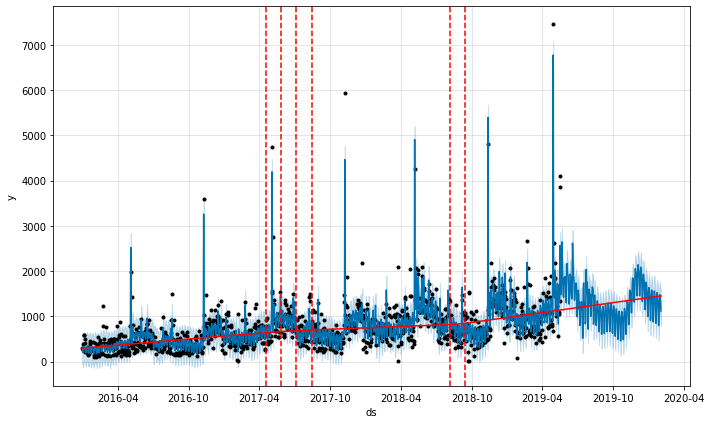

In [869]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

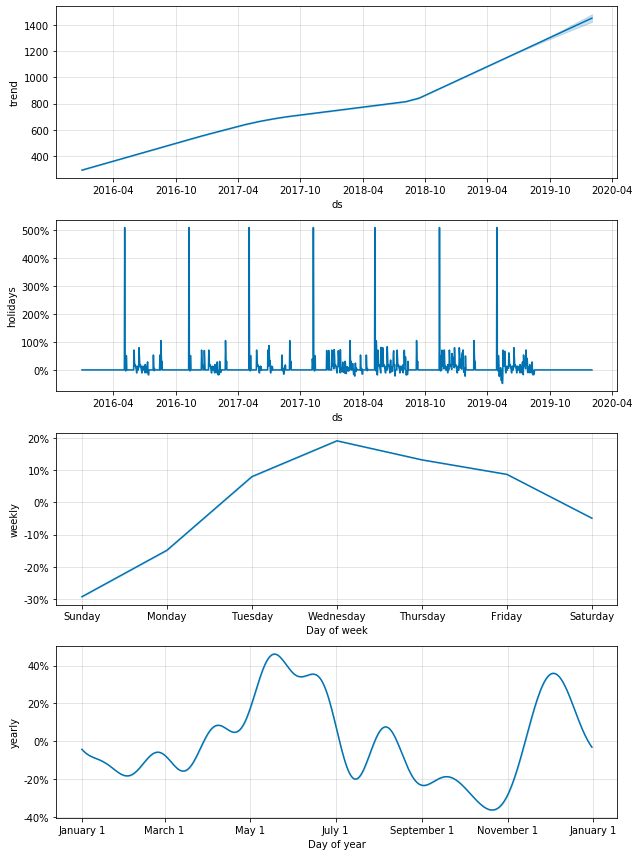

In [870]:
f = m.plot_components(forecast)

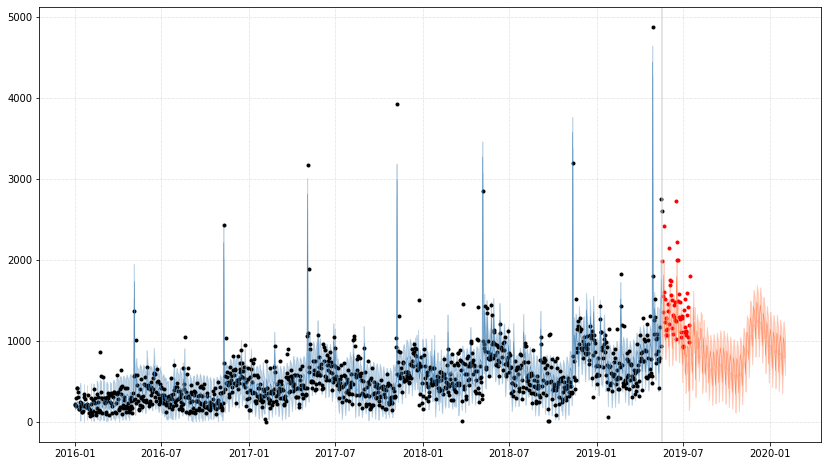

In [871]:
verif = utils.make_verif(forecast, dat_train, dat_test)
# verif['y'] = (verif['y']) ** (1/expand_factors)
verif['yhat'] = (verif['yhat']) ** (1/expand_factors)
verif['yhat_upper'] = (verif['yhat_upper']) ** (1/expand_factors)
verif['yhat_lower'] = (verif['yhat_lower']) ** (1/expand_factors)

f = utils.plot_verif(verif,date=split_date)


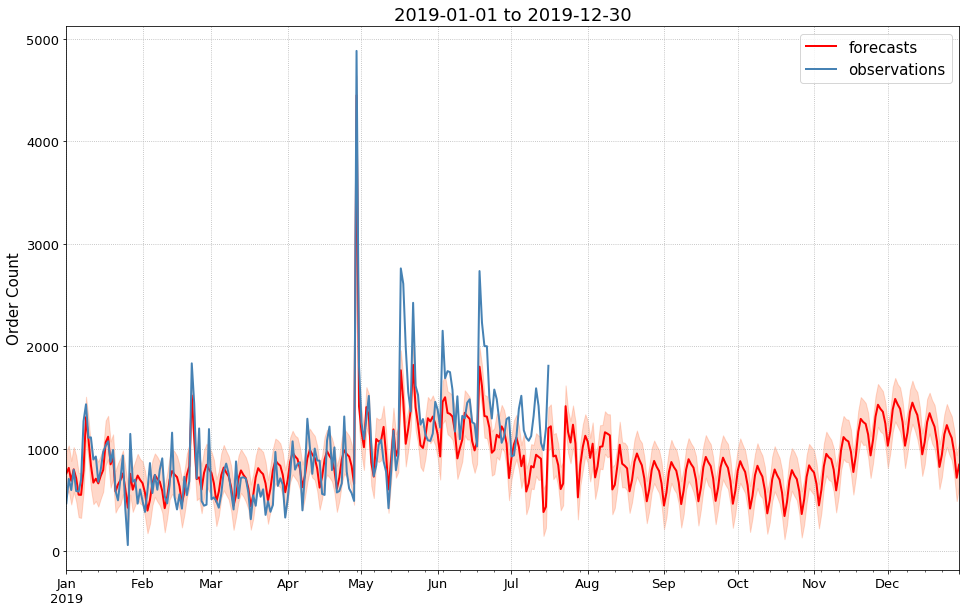

In [872]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)

utils.make_plot_block(verif, '2019-01-01', '2019-12-30', ax=ax)


# for ext in ['png']: 
#     f.savefig('../figures/forecasts_obs.{}'.format(ext), dpi=200)

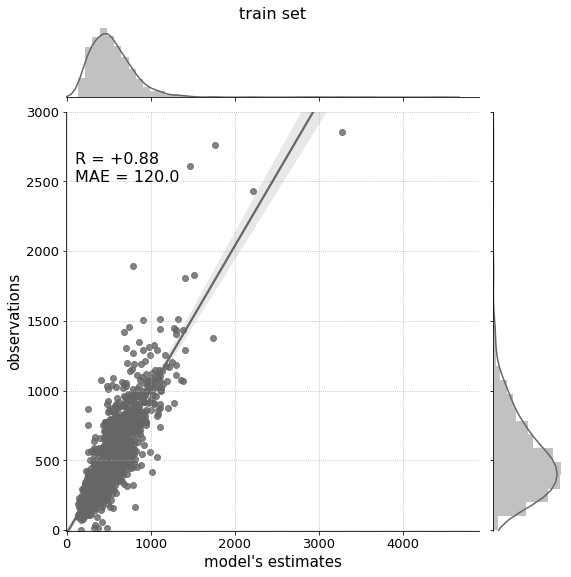

In [873]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

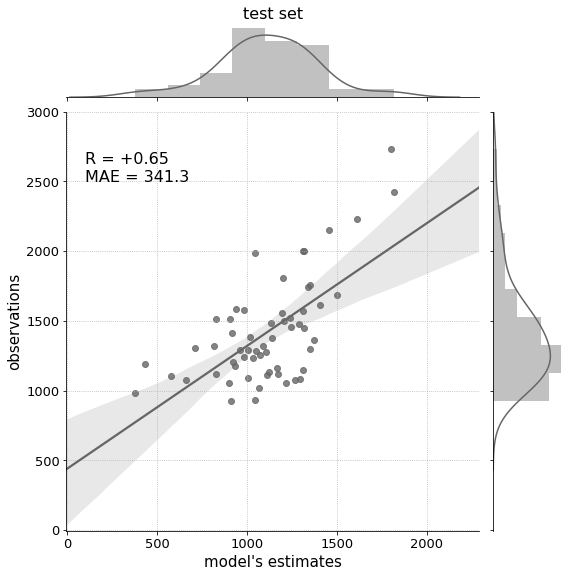

In [874]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

In [829]:
## Accruacy by weekday
def weekday(ds):
    return ds.dayofweek

verif['mae'] = np.abs(verif['y'] - verif['yhat'])
verif['mape'] = np.abs(verif['y'] - verif['yhat'])/verif['y']
verif['day_of_week'] = verif['ds'].apply(weekday)
verif.loc[verif.ds>='2019-01-01',['day_of_week','mae','mape']].groupby("day_of_week").agg("mean")

,mae,mape
day_of_week,,
0,186.945376,0.214406
1,223.982373,0.280967
2,164.653236,0.172469
3,186.518503,0.178305
4,181.760848,0.194262
5,138.041352,0.401308
6,190.997824,0.227728


In [746]:
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'VIP Sale',
  'Markdowns',
  'Tiered Promo',
  'Employee Sale',
  'Full Price Promo',
  'Extra % Off Promo',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [747]:
# This is from Prophet
df_cv = cross_validation(m_full, initial='730 days', period='15 days', horizon = '14 days')

In [748]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,2 days,59545.334709,244.019128,191.045816,0.229542,0.636000
1,3 days,72509.336106,269.275577,205.137246,0.248370,0.551667
2,4 days,92512.753036,304.159092,236.561476,0.291806,0.484571
3,5 days,83516.712008,288.992581,221.506264,0.279368,0.530588
4,6 days,65565.414248,256.057443,200.163707,0.256087,0.605294


In [749]:
# df_cv
# df_cv.loc[df_cv.mape<1,:].groupby("horizon").agg("mean").loc[:,['mape']].plot()
# df_cv.groupby("horizon").agg("mean").loc[:,['mape']].query('mape>0.9')

In [750]:
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head(5)

,horizon,mse,rmse,mae,mape,coverage
0,2 days,59545.334709,244.019128,191.045816,0.229542,0.636000
1,3 days,72509.336106,269.275577,205.137246,0.248370,0.551667
2,4 days,92512.753036,304.159092,236.561476,0.291806,0.484571
3,5 days,83516.712008,288.992581,221.506264,0.279368,0.530588
4,6 days,65565.414248,256.057443,200.163707,0.256087,0.605294


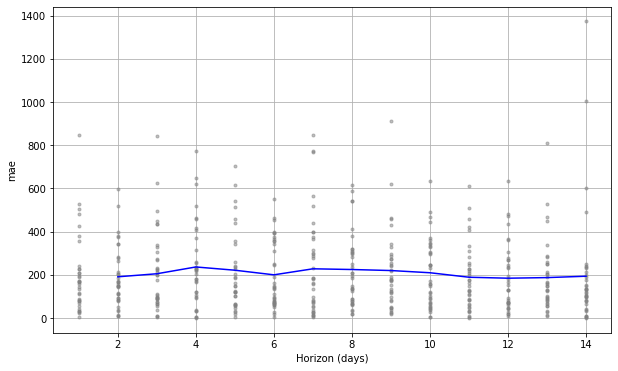

In [751]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

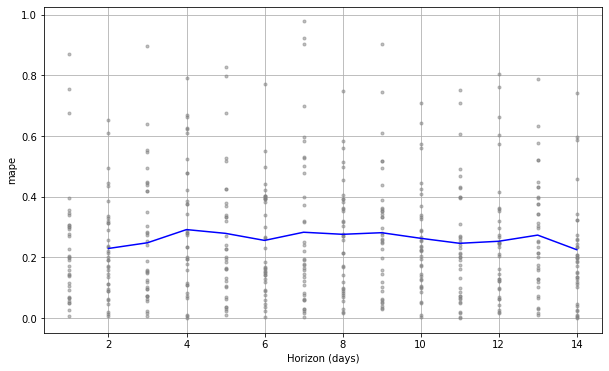

In [752]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

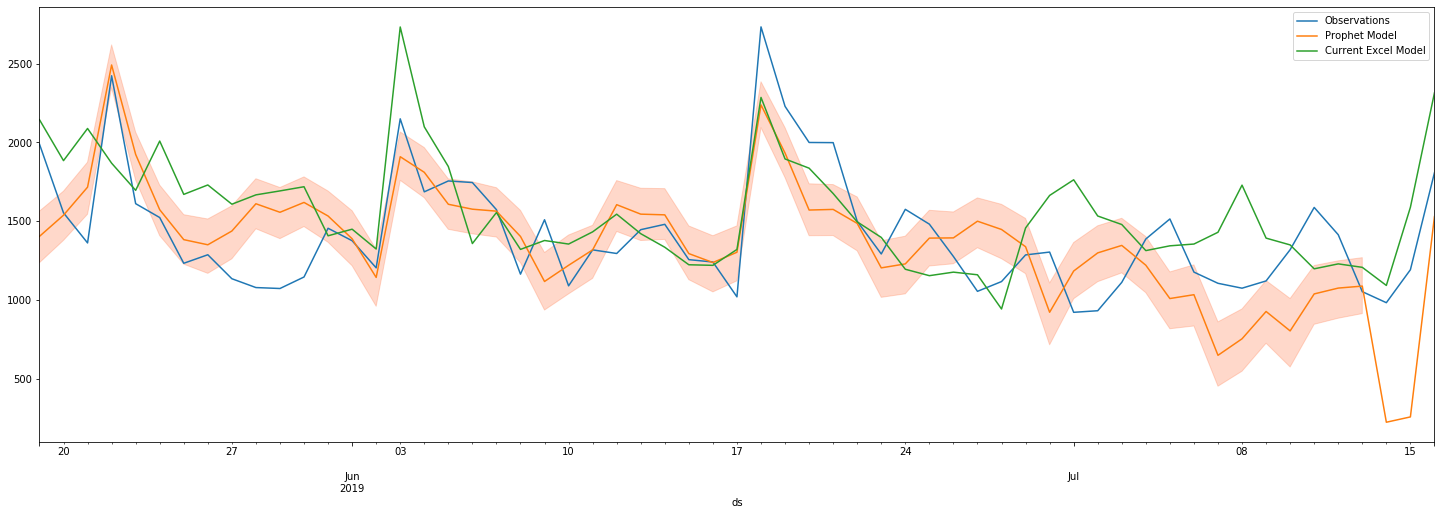

In [830]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['ds','yhat_lower','yhat_upper','yhat','y','out_cust_order_qty_curr'])
verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':'Prophet Model', 'out_cust_order_qty_curr':'Current Excel Model'} ,inplace=True)
_, ax = plt.subplots(figsize=(25,8))
verif_comp.loc[:,['Observations','Prophet Model','Current Excel Model']].plot(ax=ax)
ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)



In [754]:
print('MAPE of the Current Excel Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations'])/verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp['Prophet Model'] - verif_comp['Observations'])/verif_comp['Observations'])))


MAPE of the Current Excel Model 0.21678561658887704
MAPE of the Prophet Model Up Until 2019-05-19  0.1877296145626764


## Try Box Cox 

In [755]:
from scipy import stats

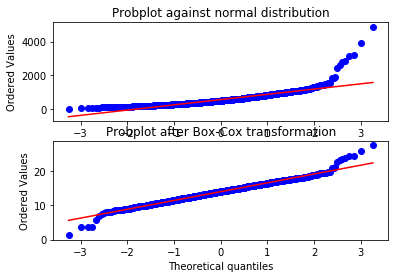

In [756]:
>>> fig = plt.figure()
>>> ax1 = fig.add_subplot(211)
>>> x = dat_train["y"]
>>> prob = stats.probplot(x, dist=stats.norm, plot=ax1)
>>> ax1.set_xlabel('')
>>> ax1.set_title('Probplot against normal distribution')
# We now use boxcox to transform the data so it’s closest to normal

>>>
>>> ax2 = fig.add_subplot(212)
>>> xt, _ = stats.boxcox(x)
>>> prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
>>> ax2.set_title('Probplot after Box-Cox transformation')
>>>
>>> plt.show()



In [757]:
# def outlier_flag(df, varname = None, window=24, std=3): 
#     dfc = df.loc[:,[varname]]
#     dfc['median']= dfc[varname].rolling(window, center=True).median()
#     dfc['std'] = dfc[varname].rolling(window, center=True).std()
#     dfc['outliers'] = ((dfc.loc[:,varname] - (dfc['median']+std*dfc['std'])) >0) | ((dfc.loc[:,varname] - (dfc['median']-std*dfc['std'])) <0)
#     dfc['outliers'] = dfc['outliers'].astype(int)
#     dfc = pd.concat([dfc[['outliers']],df], axis=1)
#     dfc.loc[:,['ds','outliers']]
#     return dfc.loc[:,['ds','outliers']]

# #### prepare holiday ds
# holidays = outlier_flag(dat_all,varname= 'y').query('outliers==1')[['ds']]
# holidays['holiday'] = 'Major Sales'
# holidays['lower_window'] = 0
# holidays['upper_window'] = 5
# holidays


# holidays = pd.read_csv('data/holiday_update_0716.csv')
# holidays.tail()

holidays = holidays_full
holidays.tail()

,ds,holiday,lower_window,upper_window,flag_data
52,2017-12-17,Extra % Off Promo,0,3,NaN
53,2019-01-17,Extra % Off Promo,0,4,NaN
54,2018-12-19,Extra % Off Promo,0,4,NaN
55,2018-08-01,Extra % Off Promo,0,5,NaN
56,2019-07-23,Extra % Off Promo,0,7,NaN


In [790]:
m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

In [791]:
# Transform
dat_train_transformed = dat_train.copy()
dat_all_transformed = dat_all.copy()

yt, y_lambda = stats.boxcox(dat_train["y"])
y_all_t , y_all_lambda = stats.boxcox(dat_all["y"])
dat_train_transformed["y"] = yt
dat_all_transformed["y"] = y_all_t
y_all_lambda

0.2000878055982773

In [792]:
dat_train_transformed.head()

,ds,y
0,2016-01-01,10.961231
1,2016-01-02,10.895184
2,2016-01-03,10.673883
3,2016-01-04,12.096402
4,2016-01-05,13.542538


In [793]:
m.fit(dat_train_transformed)
m_full.fit(dat_all_transformed)

### Test

In [794]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')

In [795]:
forecast = m.predict(future)

In [796]:
forecast.loc[forecast.ds>=split_date,:].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Employee Sale,Employee Sale_lower,Employee Sale_upper,Extra % Off Promo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1234,2019-05-19,16.165491,14.843040,18.236046,16.165491,16.165491,0.0,0.0,0.0,0.0,...,-0.122904,-0.122904,-0.122904,0.091987,0.091987,0.091987,0.0,0.0,0.0,16.527324
1235,2019-05-20,16.173133,16.165256,19.740812,16.173133,16.173133,0.0,0.0,0.0,0.0,...,-0.050901,-0.050901,-0.050901,0.093469,0.093469,0.093469,0.0,0.0,0.0,17.960243
1236,2019-05-21,16.180774,18.093954,21.541359,16.180774,16.180774,0.0,0.0,0.0,0.0,...,0.040388,0.040388,0.040388,0.094545,0.094545,0.094545,0.0,0.0,0.0,19.731367
1237,2019-05-22,16.188416,21.317835,24.920549,16.188416,16.188416,0.0,0.0,0.0,0.0,...,0.071365,0.071365,0.071365,0.095255,0.095255,0.095255,0.0,0.0,0.0,23.076692
1238,2019-05-23,16.196058,19.044772,22.359904,16.196058,16.196058,0.0,0.0,0.0,0.0,...,0.052207,0.052207,0.052207,0.095644,0.095644,0.095644,0.0,0.0,0.0,20.720361


### Validation

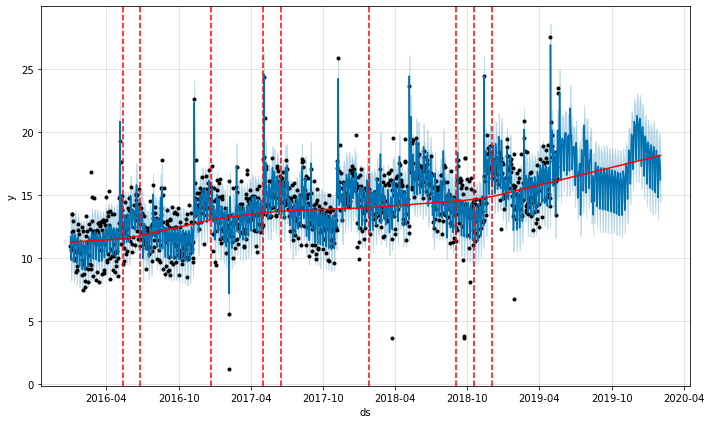

In [797]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

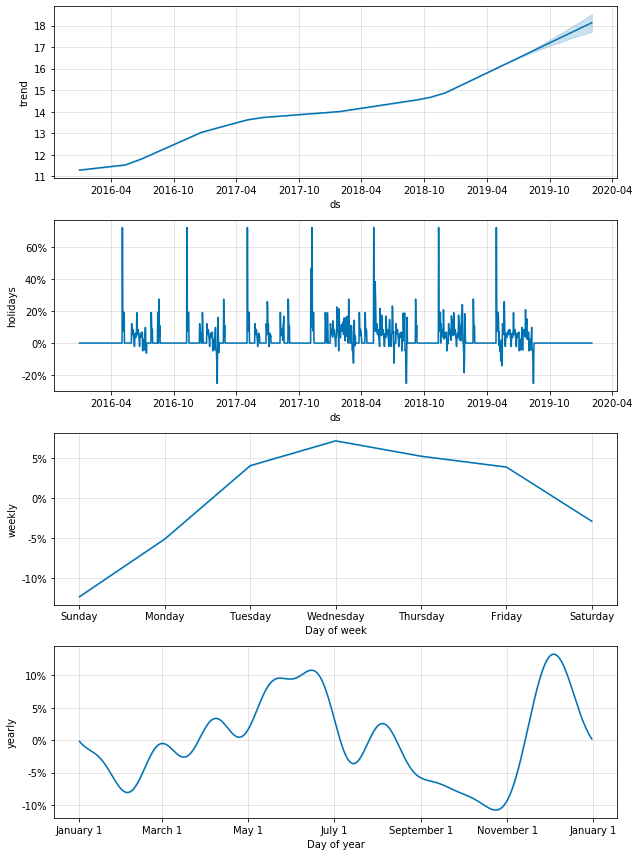

In [798]:
f = m.plot_components(forecast)

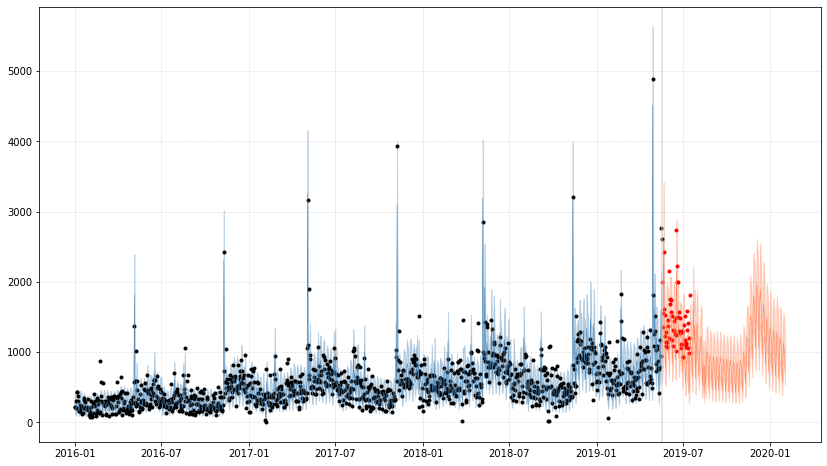

In [799]:
verif = utils.make_verif(forecast, dat_train, dat_test)
verif
from scipy.special import boxcox, inv_boxcox

verif['yhat'] = inv_boxcox(verif['yhat'], y_lambda)
verif['yhat_upper'] = inv_boxcox(verif['yhat_upper'], y_lambda)
verif['yhat_lower'] = inv_boxcox(verif['yhat_lower'], y_lambda)

f = utils.plot_verif(verif,date=split_date)

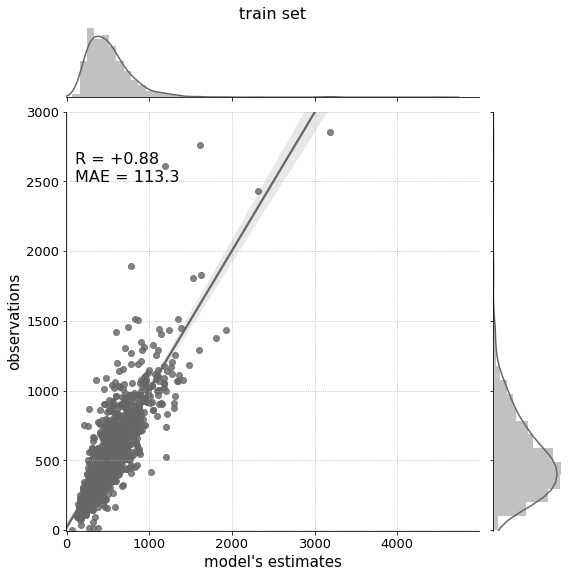

In [800]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

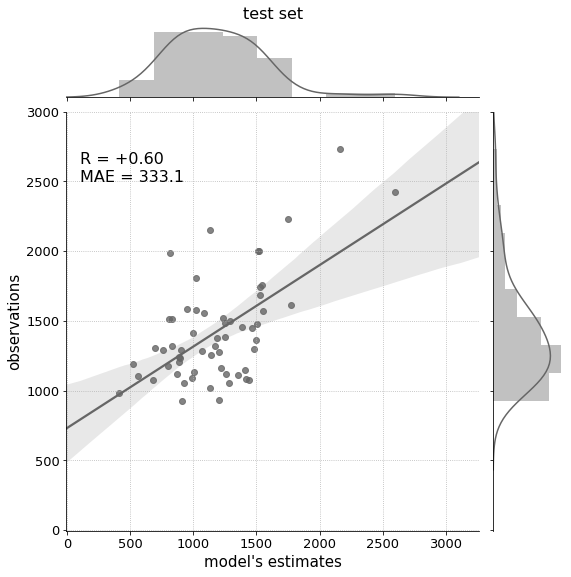

In [801]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

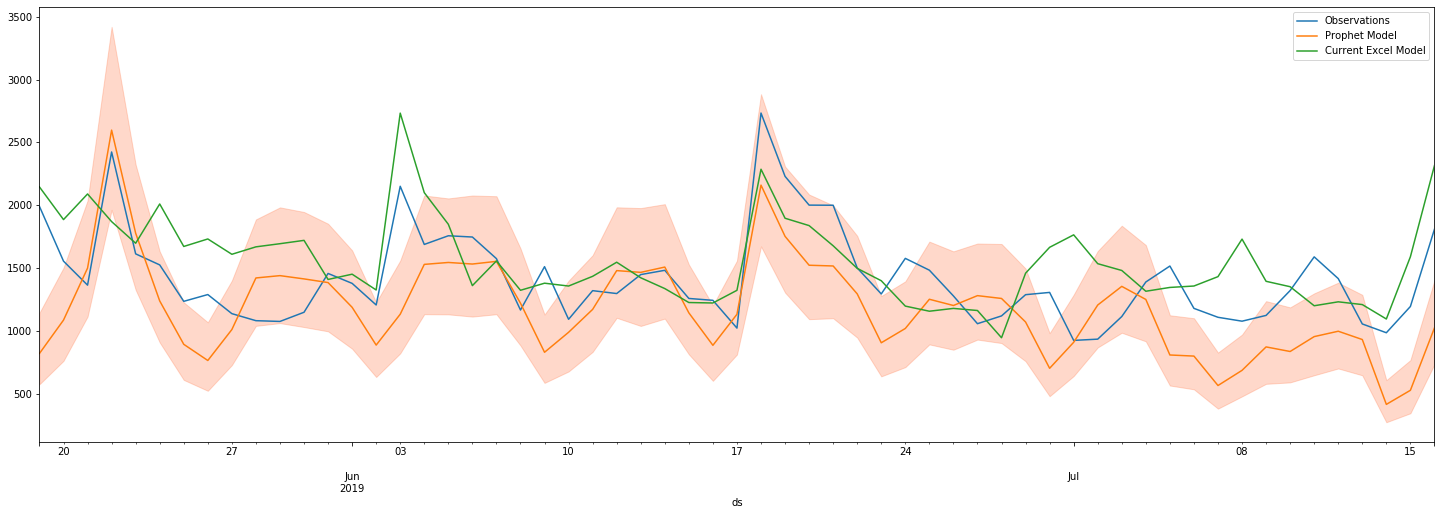

In [802]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['ds','yhat_lower','yhat_upper','yhat','y','out_cust_order_qty_curr'])
verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':'Prophet Model', 'out_cust_order_qty_curr':'Current Excel Model'} ,inplace=True)
_, ax = plt.subplots(figsize=(25,8))
verif_comp.loc[:,['Observations','Prophet Model','Current Excel Model']].plot(ax=ax)
ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)



In [803]:
print('MAPE of the Current Excel Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations'])/verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp['Prophet Model'] - verif_comp['Observations'])/verif_comp['Observations'])))


MAPE of the Current Excel Model 0.21678561658887704
MAPE of the Prophet Model Up Until 2019-05-19  0.23396602677123157


## Apendix

### log + extra regressor

In [772]:
# def markdown(ds):
#     date = pd.to_datetime(ds)
#     if date.month == 5 or date.month ==11 or (date.month==4 and date.day>=15 ) :
#         return 1
#     else:
#         return 0

# m = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='additive', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \

#            )

# m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='additive', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \

#            )

# ### Add extra regressors
# dat_train['markdown'] = dat_train['ds'].apply(markdown)
# dat_all['markdown'] = dat_all['ds'].apply(markdown)
# m.add_regressor('markdown' , prior_scale=10)
# m.fit(dat_train)

# m_full.add_regressor('markdown' , prior_scale=10)
# m_full.fit(dat_all)

# future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')
# future['markdown'] = future['ds'].apply(markdown)


### Build a Poisson Distribtion Extra Regressor based on promotions

In [773]:
# from scipy.stats import poisson

In [774]:
# fig, ax = plt.subplots(1, 1)
# >>> ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
# >>> ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)


In [775]:
# def outlier_flag(df, varname = None, window=24, std=3): 
#     dfc = df.loc[:,[varname]]
#     dfc['median']= dfc[varname].rolling(window, center=True).median()
#     dfc['std'] = dfc[varname].rolling(window, center=True).std()
#     dfc['outliers'] = ((dfc.loc[:,varname] - (dfc['median']+std*dfc['std'])) >0) | ((dfc.loc[:,varname] - (dfc['median']-std*dfc['std'])) <0)
#     dfc['outliers'] = dfc['outliers'].astype(int)
#     dfc = pd.concat([dfc[['outliers']],df], axis=1)
#     dfc.loc[:,['ds','outliers']]
#     return dfc.loc[:,['ds','outliers']]


In [776]:
# dat_train['markdown_boost'] = outlier_flag(dat_train,varname= 'y')[['outliers']]
# dat_train.query('markdown_boost == 1')

In [777]:
# if log_transform == True:
#     forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
#     forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])
#     forecast['trend'] = np.exp(forecast['trend'])
#     forecast['yhat'] = np.exp(forecast['yhat'])
# forecast.head()    
# forecast.loc[forecast.ds>='2019-04-29',['markdown','markdown_boost']]
# dat_train.loc[dat_train.ds >= '2019-04-29',:]

In [778]:
# f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)

# utils.make_plot_block(verif, '2018-07-05', '2018-07-30', ax=ax)

In [779]:
# df_cv.sort_values("mape",ascending=False)
# df_cv.groupby("ds").agg("mean").sort_values("mape",ascending=False).head()

In [780]:
# # verif.loc[verif.ds>='2018-03-20',:]
# dat_test = dat_all.copy()
# utils.median_filter(dat_test.loc[dat_test.ds.between('2018-03-20','2018-03-30'),:], varname="y" , window=10, std=1)


In [781]:
# def markdown(ds):
#     date = pd.to_datetime(ds)
#     if date.month == 5 or date.month ==11 or (date.month==4 and date.day>=15 ) :
#         return 1
#     else:
#         return 0
    
# def markdown_boost(ds):
#     date = pd.to_datetime(ds)
#     if date == pd.to_datetime('2019-04-29') or date == pd.to_datetime('2018-05-07') :
#         return 1
#     else:
#         return 0
    

# def outlier_flag(df, varname = None, window=24, std=3): 
#     dfc = df.loc[:,[varname]]
#     dfc['median']= dfc[varname].rolling(window, center=True).median()
#     dfc['std'] = dfc[varname].rolling(window, center=True).std()
#     dfc['outliers'] = ((dfc.loc[:,varname] - (dfc['median']+std*dfc['std'])) >0) | ((dfc.loc[:,varname] - (dfc['median']-std*dfc['std'])) <0)
#     dfc['outliers'] = dfc['outliers'].astype(int)
#     dfc = pd.concat([dfc[['outliers']],df], axis=1)
#     dfc.loc[:,['ds','outliers']]
#     return dfc.loc[:,['ds','outliers']]

  


# m = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \
#            ,holidays = holidays
#            )

# m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \
#            ,holidays = holidays
#            )

# ### Add extra regressors
# # dat_train['markdown'] = dat_train['ds'].apply(markdown)
# # dat_train['markdown_boost'] = dat_train['ds'].apply(markdown_boost)
# # dat_train['markdown_boost'] = outlier_flag(dat_train,varname= 'y')[['outliers']]
# # m.add_regressor('markdown')
# m.add_regressor('markdown_boost', prior_scale = 100)

# # dat_all['markdown_boost'] = outlier_flag(dat_all,varname= 'y')[['outliers']]
# # dat_all['markdown'] = dat_all['ds'].apply(markdown)
# m_full.add_regressor('markdown_boost')


In [782]:
# ### HACKKKKK Add extra regressor
# holidays_hack['date_utc'] = pd.to_datetime(holidays_hack['date_utc'])
# dat_train = dat_train.loc[:,['ds','y']].join(holidays_hack.set_index('date_utc').loc[:,'markdown_boost'],on="ds", how="left")
# dat_all = dat_all.loc[:,['ds','y']].join(holidays_hack.set_index('date_utc').loc[:,'markdown_boost'],on="ds", how="left")

In [783]:
# m.fit(dat_train)
# m_full.fit(dat_all)

In [784]:
# # m.component_modes
# dat_all.query('markdown_boost>0').head()

### Test

In [785]:
# # predict forward_days 
# future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')
# # Add extra regressors
# # future['markdown'] = future['ds'].apply(markdown)
# # future['markdown_boost'] = future['ds'].apply(markdown_boost)

# # ### Hack
# # # future.query('markdown_boost==1')
# # future = future.join(dat_all.loc[:,['ds','markdown_boost']].set_index('ds'), on = "ds")
# # future['markdown_boost'] = future['markdown_boost'].fillna(0).astype(int)
# # future.query('markdown_boost==1')



# ### HACK II
# future = future.loc[:,['ds']].join(holidays_hack.set_index('date_utc').loc[:,'markdown_boost'],on="ds", how="left")
# future['markdown_boost'] = future['markdown_boost'].fillna(0)
# # future.query('markdown_boost>0')

In [786]:
# if log_transform == True:
#     forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
#     forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])
#     forecast['trend'] = np.exp(forecast['trend'])
#     forecast['yhat'] = np.exp(forecast['yhat'])
# forecast.head()    
# forecast.loc[forecast.ds>='2019-04-29',['markdown','markdown_boost']]
# dat_train.loc[dat_train.ds >= '2019-04-29',:]

In [787]:
# m = Prophet(changepoint_prior_scale=0.05, seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \
#            ,holidays = holidays
#            )


# m.add_country_holidays(country_name='US') # Add US holiday  ,(careful for overfitting)

# changepoint_prior_scale = 0.05 is default, Increase will tend to overfit the model
# Seasonality mode = multiplicative will change the degree of seasonality based on degree of trend


# def markdown(ds):
#     date = pd.to_datetime(ds)
#     if date.month == 5 or date.month ==11 or (date.month==4 and date.day>=15 ) :
#         return 1
#     else:
#         return 0

# m = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \
# #            ,holidays = holidays
#            )

# m_full = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.9 ,\
#             seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
#             holidays_prior_scale = 10, \
#             yearly_seasonality=True, \
#             weekly_seasonality=True, \
#             daily_seasonality=False \
# #            ,holidays = holidays
#            )

# ### Add extra regressors
# dat_train['markdown'] = dat_train['ds'].apply(markdown)
# dat_all['markdown'] = dat_all['ds'].apply(markdown)
# m.add_regressor('markdown')
# m.fit(dat_train)

# m_full.add_regressor('markdown')
# m_full.fit(dat_all)

In [788]:
# future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')
# future['markdown'] = future['ds'].apply(markdown)


### Machine Learning Model to Capture the Markdown Event

In [789]:
# def markdown_boost(ds):
#     date = pd.to_datetime(ds)
#     if date == pd.to_datetime('2019-04-29') or date == pd.to_datetime('2018-05-07') :
#         return 1
#     else:
#         return 0